# Optimized Image Sampling for Explanations 

In [1]:
import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
from skimage.transform import resize
from tqdm import tqdm
from scipy import linalg
import time
import math
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"

Using TensorFlow backend.


## Change code below to incorporate your *model* and *input processing*

### Define your model here:

In [2]:
# from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions



from keras import backend as K

# from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions


In [3]:
class Model():
    def __init__(self):
        K.set_learning_phase(0)
#         self.model = ResNet50()
        self.model = VGG16(include_top=True, weights='imagenet') 
        self.input_size = (224, 224)
        
    def run_on_batch(self, x):
        return self.model.predict(x)

### Load and preprocess image

In [4]:
from keras.preprocessing import image

In [5]:
def load_img(path):
    img = image.load_img(path, target_size=model.input_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [6]:
image.load_img

<function keras_preprocessing.image.utils.load_img(path, grayscale=False, color_mode='rgb', target_size=None, interpolation='nearest')>

## RISE

In [34]:
import pandas as pd

batch_size = 100
config = {}
config['learning_rate'] = 0.02
config['momentum'] = 0.1
img_name = "persian cat"

def gen_initial_mask( s, p1):
    
    grid = np.random.rand(s, s) > p1
    grid = grid.astype('float32')
    return grid

def upsize_mask(s, mask):
    
    cell_size = np.ceil(np.array(model.input_size) / s)
    up_size = (s + 1) * cell_size
    
    masks = np.empty((224, 224))

    # Random shifts
    x = np.random.randint(0, cell_size[0])
    y = np.random.randint(0, cell_size[1])
    # Linear upsampling and cropping
    masks[:, :] = resize(mask, up_size, order=1, mode='reflect',
            anti_aliasing=False)[x:x + model.input_size[0], y:y + model.input_size[1]]
    
    masks = masks.reshape(*model.input_size, 1)
    
    return masks


def do_plot(ax):
    ax.plot([1,2,3], [4,5,6], 'k.')

def normalize(m):
    m = np.maximum(m, 0)
    m_max = m.max() 
    if m_max != 0: 
        m = m / m_max
    return m


def explain_and_update(model, inp, N, class_idx, itr, img):
    preds = []
    s = 8
    # Make sure multiplication is being done for correct axes
    
    ct = 20
    cols = 3
    rows = int(math.ceil(ct / cols))

    
    ct = 0
    pred_prev = 0.0
    m = np.empty((inp.shape[1], inp.shape[1]))
    
    for i in range(0, N):
    
        if i == 0:
            mask = gen_initial_mask(s, 0.7)
            np.save('mask_without_upsample.npy', mask)
            
            mask_ = upsize_mask(s, mask)
            np.save('mask_with_upsample.npy', mask_)
#             print(mask.shape, mask_[:,:,0].shape)
            plt.figure()
            plt.imshow(mask_[:,:,0])
#             fig.tight_layout()
            print('initial mask')
#             plt.savefig("initial_mask.pdf")
#             plt.show()
        masked_inp = mask_*inp
        masked = masked_inp.reshape(1, masked_inp.shape[1], masked_inp.shape[2], 
                                    masked_inp.shape[3])
        pred = model.run_on_batch(masked)
#         print(pred)
        pred_curr = pred[:,class_idx]
        delta_pred = pred_curr - pred_prev
#         print(delta_pred)
        # current for next iteration
        mask_prev = np.copy(mask)
        obs_r_prev, obs_c_prev= np.where(mask > 0.0)
        obs_prev = pd.DataFrame([obs_r_prev, obs_c_prev])
        
        masked_r_prev, masked_c_prev = np.where(mask == 0.0)
        obs_prev = pd.DataFrame([obs_r_prev.T, obs_c_prev.T])
        
        # ith iteration input sample selection and mask update
        mask[obs_r_prev, obs_c_prev] = np.random.rand(len(obs_r_prev)) > (1-pred[:,class_idx])
        mask[masked_r_prev, masked_c_prev] = np.random.rand(len(masked_r_prev)) > pred[:,class_idx]
        
#         mask[masked_r_prev, masked_c_prev] = np.where()
        
#         print('mask after changes', mask)
        delta_mask = np.subtract(mask , mask_prev)
#         print(delta_mask)
        # regularizer
        if delta_pred < 0:
#             print('delta pred negative')
            r, c = np.where(delta_mask < 0)
#             print('before less', mask[r,c])
            
            mask[r,c] = mask[r,c] - config['learning_rate']*delta_pred*mask[r,c]
#             print('after less', mask[r,c])
            
            
            r, c = np.where(delta_mask > 0)
#             print('before more', mask[r,c])
            
            mask[r,c] =  mask[r,c] + config['learning_rate']*delta_pred*mask[r,c]
#             print('after more', mask[r,c])
            
#             plt.figure()
#             plt.imshow(m)

        if delta_pred >= 0:
#             print('delta pred positive')
            r, c = np.where(delta_mask < 0)
#             print('before less', mask[r,c])
            
            mask[r,c] = mask[r,c] + config['learning_rate']*delta_pred*mask[r,c]
#             print('after less', mask[r,c])
            
            
            r, c = np.where(delta_mask > 0)
#             print('before more', mask[r,c])
            
            mask[r,c] =  mask[r,c] - config['learning_rate']*delta_pred*mask[r,c]
#             print('after more', mask[r,c])
            
#             plt.figure()
#             plt.imshow(m)
    
        obs_r_curr, obs_c_curr= np.where(mask > 0.0) 
        obs_curr = pd.DataFrame([obs_r_curr, obs_c_curr])
#         delta_mask = np.subtract(mask , mask_prev)
#         print('mask after regulariation',mask)
        # resize the updated mask
#         mask = normalize(mask)
        
        new_mask_ = upsize_mask(s, mask)
#         print('upsized',new_mask_)
        # mask after ith iteration
        mask_ = new_mask_
        m += new_mask_[:,:,0]
#         m = m.T.dot(new_mask_[:,:,0])
               
#         m = normalize(m)
        
        if ((i==0) and ((np.mean(m) < 0) or (np.mean(m) >5) or np.isnan(np.mean(m)))):
#             del m
            return None
        
        if ((i%100 == 0)):
            
            print(i, np.mean(m), np.std(m))
#             if ((np.std(m) > 2)|(np.isinf(np.std(m)))):
#                 break
#             print(i)
            plt.figure()
            plt.imshow(img)
            plt.imshow(m, cmap='jet', alpha=0.5)
#             print('Accuracy', pred[:,class_idx])
#             plt.savefig("{}/mask_{}_{}.pdf".format(img_name, img_name, i))
            plt.show()
            np.save('/rhome/s7thakur/RISE/inputs/'+os.path.splitext(os.path.basename(image_file_path))[0]+ '_' + str(class_idx) +'_saloise_'+ str(i) +'.npy', m)
    
#             ct = ct+1
   
#         if i == 2000: config['learning_rate'] =  0.05
#         if i == 5000: config['learning_rate'] = 0.07
        pred_prev = np.copy(pred[:,class_idx])

        
        
    return m



---

In [9]:
def class_name(idx):
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]

## Running explanations

In [10]:
model = Model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [37]:
# import shutil

# input_dir = '/rhome/s7thakur/RISE/imagenet_test/inputs/'
# for f in glob.glob('/rhome/s7thakur/RISE/imagenet_test/rise/resnet/*.npy'):
#     print(f)
#     for clas in ['Apple','Bicycle','Cart','Horse','Orange','Dolphin','Cricket','Zucchini','']:
        
#         for img in glob.glob('/rhome/s7thakur/OIDv4_ToolKit/OID/Dataset/test/' + clas + '/*.jpg'):
# #             print(f.split('_')[0])
#             if os.path.basename(f).split('_')[0] in img:
#                 print(img)
                
#                 shutil.copy(img, input_dir)
                
                

In [24]:
import shutil

image_file_path = '/rhome/s7thakur/RISE/images/viaduct1.jpg'

# mask_file_path = os.path.join('/rhome/s7thakur/RISE/inputs/masks/', 'importance_matrix_'+ os.path.splitext(os.path.basename(image_file_path))[0] +'.npy')

In [25]:
img, x = load_img(image_file_path)

In [26]:
x.shape

(1, 224, 224, 3)

(-0.5, 223.5, 223.5, -0.5)

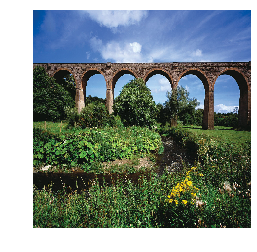

In [27]:
plt.figure()
plt.imshow(img)
plt.axis('off')
# plt.savefig('../eccv2020/egycat2.svg', bbox_inches='tight', pad_inches=0)

In [28]:
# predict classification category (label)
preds = model.run_on_batch(x)
class_idx = np.argmax(preds, axis=1)[0]
print(class_idx)
preds = decode_predictions(preds, top=5)

# hopefully, we can say that the prediction does in fact makes sense
for i, (imagenetID, label, prob) in enumerate(preds[0]):
    print('{}. {}: {:.2f}%'.format(i + 1, label, prob * 100))
    

888
1. viaduct: 100.00%
2. steel_arch_bridge: 0.00%
3. pier: 0.00%
4. valley: 0.00%
5. rapeseed: 0.00%


initial mask


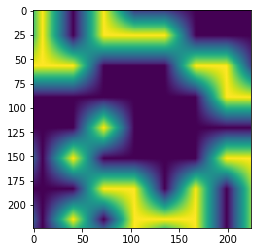

In [43]:
N =5000
itr = 1
sal_oise = explain_and_update(model, x, N, class_idx, itr, img)

# np.save('/rhome/s7thakur/RISE/inputs/'+os.path.splitext(os.path.basename(image_file_path))[0]+ '_' + str(class_idx) +'_saloise_'+ str(N)+'_iter_1.npy', sal_oise)


In [443]:
np.save('golden-retriever5_oise_run.npy', sal_oise)

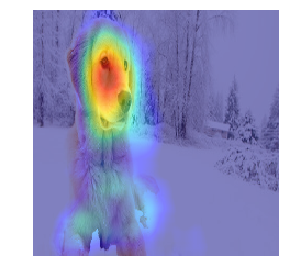

In [444]:
class_idx = class_idx
# plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(img)
plt.imshow(process_sal(sal_oise), cmap='jet', alpha=0.5)
plt.tight_layout()
plt.savefig('golden-retriever5_oise_run.png')
plt.savefig('golden-retriever5_oise_run.svg')

# plt.colorbar()
plt.show()

In [18]:
def process_sal(sal_oise):
    # check for pixels which are highlighted due to the mask in focus
    sal_oise = sal_oise - sal_oise.mean()
#     sal_oise = (sal_oise + 1e-10) / (np.linalg.norm(sal_oise, 2) + 1e-10)
#     sal_oise = cv2.resize(sal_oise, (224, 224), cv2.INTER_LINEAR)
    sal_oise = np.maximum(sal_oise, 0)
    sal_oise = sal_oise / sal_oise.max()
    
    return sal_oise


In [446]:
sal = process_sal(sal_oise)